### If there are no import errors - the environment was set up correctly:

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision import datasets, transforms

In [2]:
torch.__version__

'1.6.0'

### Choosing computation device:

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Now we will download (if needed) and set up MNIST datasets:

*Training* dataset first:

In [4]:
train_set = datasets.MNIST("./", train=True, download=True)
train_set

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train

And then *Validation* dataset:

In [5]:
valid_set = datasets.MNIST("./", train=False, download=True)
valid_set

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test

It seems that the elements in `torchvision` datasets are tuples, where the first item is `PIL.Image.Image`, the second - a numeric value which is presented in the image. Although datasets do have `data` and `targets` attributes, which are `tensors` by themselves, `DataLoader` takes as an input dataset, where the first item in each element must be tensor. Therefore it's best to convert them to tensors during the import.

In [6]:
train_set[3600]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FA304149160>, 8)

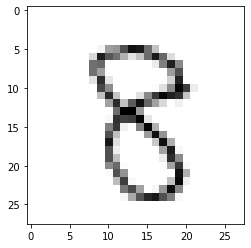

In [7]:
plt.imshow(train_set[3600][0], cmap='gray_r')
plt.show()

In [8]:
type(train_set.data), type(train_set.data[3600]), train_set.targets[3600]

(torch.Tensor, torch.Tensor, tensor(8))

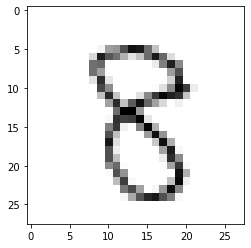

In [9]:
plt.imshow(train_set.data[3600], cmap='gray_r')
plt.show()

In [10]:
train_set = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
valid_set = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())

In [11]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=100, shuffle=True, num_workers=4)

In [12]:
image, label = train_set[3600]
image.shape, label

(torch.Size([1, 28, 28]), 8)

### Building neural network:

A _deep-learning_ model is a directed, acyclic graph of layers. A first layer will learn small local patterns such as edges, a second layer will learn larger patterns made of the features of the first layer, and so on.

The most common instance is a linear stack of layers, mapping a single input to a single output:

In [13]:
model = nn.Sequential(
    nn.Linear(784, 196), # input size = 28x28 = 784
    nn.ReLU(),
    nn.Linear(196, 98),
    nn.ReLU(),
    nn.Linear(98, 10),
    nn.Softmax(dim=1)
).to(device)
model

Sequential(
  (0): Linear(in_features=784, out_features=196, bias=True)
  (1): ReLU()
  (2): Linear(in_features=196, out_features=98, bias=True)
  (3): ReLU()
  (4): Linear(in_features=98, out_features=10, bias=True)
  (5): Softmax(dim=1)
)

Here _ReLU is **activation function**_ (also called a non-linearity). Without it the Dense layer
would consist of two linear operations - a dot product and an addition (output = dot(W, input) + b).
So the layer could only learn linear transformations of the input data: the hypothesis space (a space of possibilities) of the layer would be the set of all possible linear transformations of the input data. Such a hypothesis space is too restricted and wouldn't benefit from multiple layers of representations.

_**Loss function** (objective function)_ - the quantity that will be minimized during training. Represents a measure of success for the task at hand:

In [14]:
criterion = nn.MSELoss()

***Optimizer*** - determines how the network will be updated based on the _loss function_. It implements a specific variant of stochastic gradient descent (SGD):

In [15]:
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

In [16]:
history = dict(train_loss=[], valid_loss=[], train_acc=[], valid_acc=[])

In [17]:
epochs = 20

In [18]:
for epoch in range(1, epochs + 1):
    train_loss = 0.
    valid_loss = 0.
    train_acc = 0.
    valid_acc = 0.
    
    for data, target in train_loader:
        # Convert target to one-hot encoding (because of using the MSELoss)
        target = torch.zeros(data.size(0), 10).scatter_(1, target[:, None], 1.)

        data, target = data.to(device), target.to(device) # Move to GPU if one is available
        optimizer.zero_grad()
        output = model(data.view(data.size(0), -1))
        output = output.to(device) # Move to GPU if one is available
               
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (torch.argmax(output, 1) == torch.argmax(target, 1)).float().sum()
    
    with torch.no_grad():
        for data, target in valid_loader:
            target = torch.zeros(data.size(0), 10).scatter_(1, target[:, None], 1.)
            
            data, target = data.to(device), target.to(device) # Move to GPU if one is available
            output = model(data.view(data.size(0), -1))
            output = output.to(device) # Move to GPU if one is available
            loss = criterion(output, target)
            
            valid_loss += loss.item()
            valid_acc += (torch.argmax(output, 1) == torch.argmax(target, 1)).float().sum()
    
    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)
    train_acc /= len(train_set)
    valid_acc /= len(valid_set)
    
    history["train_loss"].append(train_loss)
    history["valid_loss"].append(valid_loss)
    history["train_acc"].append(train_acc)
    history["valid_acc"].append(valid_acc)
   
    print('Epoch: {:0>2}, train_loss: {:.5f}, valid_loss: {:.5f}, train_acc: {:.5f}, valid_acc: {:.5f}'.format(
        epoch, train_loss, valid_loss, train_acc, valid_acc))

Epoch: 01, train_loss: 0.01276, valid_loss: 0.00694, train_acc: 0.91437, valid_acc: 0.95630
Epoch: 02, train_loss: 0.00568, valid_loss: 0.00507, train_acc: 0.96375, valid_acc: 0.96660
Epoch: 03, train_loss: 0.00415, valid_loss: 0.00433, train_acc: 0.97375, valid_acc: 0.97190
Epoch: 04, train_loss: 0.00321, valid_loss: 0.00425, train_acc: 0.97992, valid_acc: 0.97270
Epoch: 05, train_loss: 0.00267, valid_loss: 0.00375, train_acc: 0.98327, valid_acc: 0.97530
Epoch: 06, train_loss: 0.00223, valid_loss: 0.00349, train_acc: 0.98633, valid_acc: 0.97700
Epoch: 07, train_loss: 0.00184, valid_loss: 0.00317, train_acc: 0.98862, valid_acc: 0.97990
Epoch: 08, train_loss: 0.00168, valid_loss: 0.00330, train_acc: 0.98952, valid_acc: 0.97890
Epoch: 09, train_loss: 0.00143, valid_loss: 0.00328, train_acc: 0.99133, valid_acc: 0.97910
Epoch: 10, train_loss: 0.00126, valid_loss: 0.00345, train_acc: 0.99228, valid_acc: 0.97850
Epoch: 11, train_loss: 0.00111, valid_loss: 0.00360, train_acc: 0.99358, valid_a

### Plotting the training and validation loss:

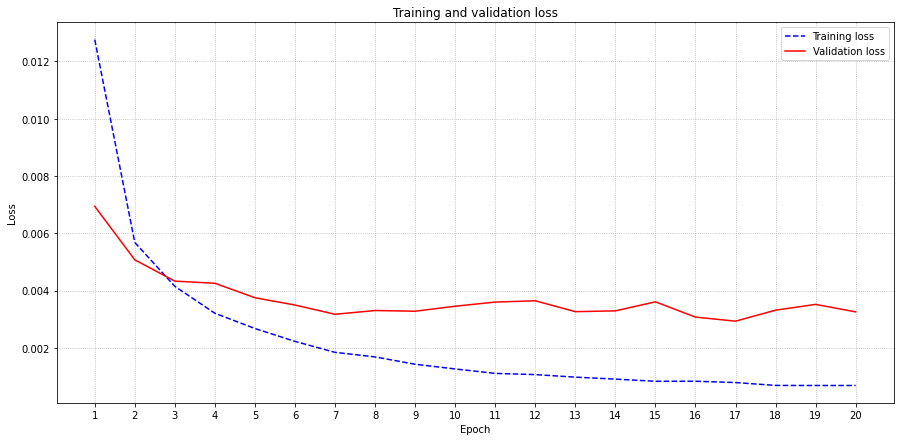

In [19]:
plt.figure(figsize=(15,7))
plt.grid(True, which="both", axis="both", linestyle=':')
plt.plot(range(1, epochs + 1), history["train_loss"], 'b--', label="Training loss")
plt.plot(range(1, epochs + 1), history["valid_loss"], 'r-', label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epoch")
plt.xticks(range(1, epochs + 1))
plt.ylabel("Loss")
plt.legend()
plt.show()

### Plotting the training and validation accuracy:

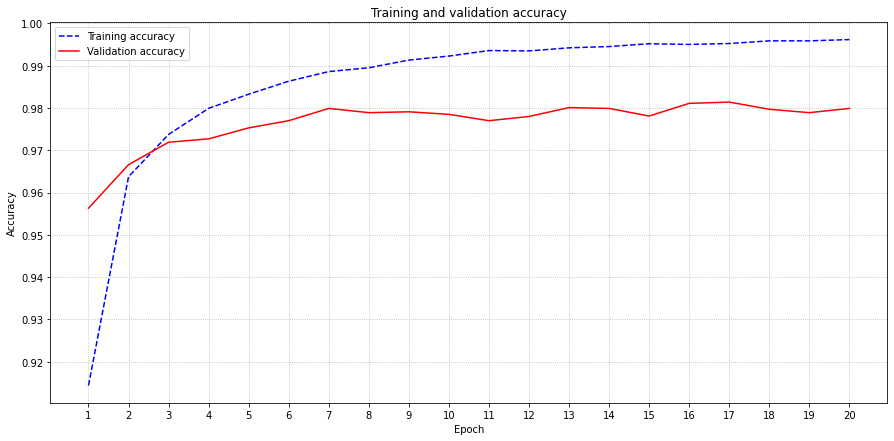

In [20]:
plt.figure(figsize=(15,7))
plt.grid(True, which="both", axis="both", linestyle=':')
plt.plot(range(1, epochs + 1), history["train_acc"], 'b--', label="Training accuracy")
plt.plot(range(1, epochs + 1), history["valid_acc"], 'r-', label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epoch")
plt.xticks(range(1, epochs + 1))
plt.ylabel("Accuracy")
plt.legend()
plt.show()